In [1]:
!pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import t, norm, chi2, jarque_bera
import yfinance as yf
import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
sns.set_style('whitegrid')

In [4]:
end_date = dt.datetime.now()

start_date = end_date - dt.timedelta(days=5*365)

tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN']

weights = np.array([0.25, 0.25, 0.25, 0.25])

print(f"Fetching data from {start_date.date()} to {end_date.date()}.")
print(f"Tickers: {tickers}")
print(f"Weights: {weights}")

Fetching data from 2020-11-03 to 2025-11-02.
Tickers: ['AAPL', 'MSFT', 'GOOG', 'AMZN']
Weights: [0.25 0.25 0.25 0.25]


In [5]:
# Download all available data for the tickers
# We add 'group_by="column"' to ensure a consistent structure
all_data = yf.download(tickers, start=start_date, end=end_date, group_by='column')

# --- Error Check ---
if all_data.empty:
    print("Error: No data downloaded. DataFrame is empty.")
else:
    print("Data downloaded successfully.")

    # --- Debugging Step ---
    # print(f"DataFrame Columns Structure:\n{all_data.columns}")

    try:
        # --- SOLUTION: Use 'Close' instead of 'Adj Close' ---
        stock_data = all_data['Close']

        # Check for any missing values (NaN) in the 'Close' data
        print(f"\nMissing values in Close data:\n{stock_data.isnull().sum()}")

        # Fill missing values, if any, using forward fill
        stock_data.ffill(inplace=True)

        # Display the first 5 rows of the 'Close' data
        print("\nClose Prices (Head):")
        print(stock_data.head())

    except KeyError as e:
        print("\n--- FATAL ERROR ---")
        print(f"KeyError: {e} still occurred.")
        print("Please check the 'DataFrame Columns Structure' printed above.")

[*********************100%***********************]  4 of 4 completed

Data downloaded successfully.

Missing values in Close data:
Ticker
AAPL    0
AMZN    0
GOOG    0
MSFT    0
dtype: int64

Close Prices (Head):
Ticker            AAPL        AMZN       GOOG        MSFT
Date                                                     
2020-11-03  107.426956  152.420502  81.949692  197.930298
2020-11-04  111.813919  162.057999  86.862076  207.480225
2020-11-05  115.782585  166.100006  87.569237  214.096115
2020-11-06  115.651054  165.568497  87.488792  214.508408
2020-11-09  113.341743  157.186996  87.550873  209.397919


In [6]:
# --- Check if stock_data exists before calculating returns ---
if 'stock_data' in locals() and not stock_data.empty:
    # Calculate daily log returns from 'Close' prices
    log_returns = np.log(stock_data / stock_data.shift(1))

    # Drop the first row (it will be NaN)
    log_returns = log_returns.dropna()

    # Display the first 5 rows of the log-returns DataFrame
    print("\nDaily Log-Returns (Head):")
    print(log_returns.head())
else:
    print("\nCannot calculate log-returns because stock_data is empty or not defined.")


Daily Log-Returns (Head):
Ticker          AAPL      AMZN      GOOG      MSFT
Date                                              
2020-11-04  0.040025  0.061311  0.058216  0.047121
2020-11-05  0.034878  0.024636  0.008108  0.031389
2020-11-06 -0.001137 -0.003205 -0.000919  0.001924
2020-11-09 -0.020170 -0.051949  0.000709 -0.024113
2020-11-10 -0.003014 -0.035195 -0.012908 -0.034377


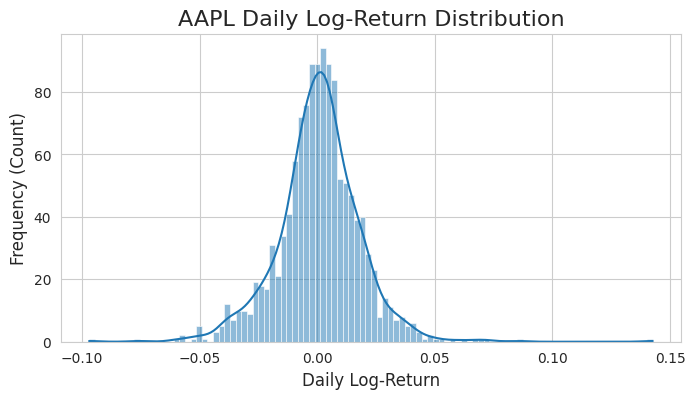

In [7]:
# --- Check if log_returns exists before plotting ---
if 'log_returns' in locals() and not log_returns.empty:

    # Select a single stock to plot (e.g., 'AAPL')
    stock_to_plot = 'AAPL'

    plt.figure(figsize=(8, 4))

    # Plot the histogram using seaborn's distplot
    # 'bins=100' creates 100 small bars for a smoother look
    # 'kde=True' adds a smooth line (Kernel Density Estimate) over the bars
    sns.histplot(log_returns[stock_to_plot], bins=100, kde=True)

    # Set a clear title for the chart [cite: 138, 139]
    plt.title(f'{stock_to_plot} Daily Log-Return Distribution', fontsize=16)
    plt.xlabel('Daily Log-Return', fontsize=12)
    plt.ylabel('Frequency (Count)', fontsize=12)
    plt.show()

else:
    print("\nCannot plot histogram because log_returns is not defined.")

In [8]:
# --- Check if log_returns exists before calculating ---
if 'log_returns' in locals() and not log_returns.empty:

    # Calculate the mean of daily log returns for each stock
    mean_returns = log_returns.mean()

    # Calculate the variance of daily log returns
    variance_returns = log_returns.var()

    # Calculate the skewness of daily log returns
    skewness_returns = log_returns.skew()

    # Calculate the kurtosis of daily log returns
    kurtosis_returns = log_returns.kurt()

    # Create a new DataFrame to store these summary statistics
    summary_stats = pd.DataFrame({
        'Mean': mean_returns,
        'Variance': variance_returns,
        'Skewness': skewness_returns,
        'Kurtosis': kurtosis_returns
    })

    # Display the summary table
    print("Summary Statistics for Daily Log-Returns:")
    print(summary_stats)

else:
    print("\nCannot calculate summary statistics because log_returns is not defined.")

Summary Statistics for Daily Log-Returns:
            Mean  Variance  Skewness  Kurtosis
Ticker                                        
AAPL    0.000736  0.000314  0.255621  5.216905
AMZN    0.000376  0.000491 -0.087426  5.166162
GOOG    0.000985  0.000374 -0.076018  3.436537
MSFT    0.000767  0.000264  0.091569  2.975711


In [9]:
# --- Check if log_returns exists before calculating ---
if 'log_returns' in locals() and not log_returns.empty:

    # 1. Combine all stock returns into one single 1D array
    # .values gets all data, .flatten() turns the 2D table into a 1D list
    all_returns = log_returns.values.flatten()

    # 2. Fit a normal distribution to the data
    # This gives us the overall mean (mu) and standard deviation (sigma)
    mu, sigma = norm.fit(all_returns)

    # 3. Calculate 95% Confidence Interval for the Mean (mu)
    n = len(all_returns)

    # Calculate Standard Error of the Mean (SEM)
    sem = sigma / np.sqrt(n)

    # Get the 95% confidence interval for the mean
    # We use norm.ppf(0.975) to get the z-score (which is ~1.96)
    # Formula: mean +/- z_score * sem
    mean_ci = (mu - norm.ppf(0.975) * sem, mu + norm.ppf(0.975) * sem)

    # 4. Calculate 95% Confidence Interval for the Standard Deviation (sigma)
    # This uses the Chi-square distribution
    df = n - 1  # Degrees of freedom

    # Chi-square values for the 2.5th and 97.5th percentiles
    chi2_lower = chi2.ppf(0.025, df)
    chi2_upper = chi2.ppf(0.975, df)

    # Calculate the interval
    # Note: We use sample variance (sigma**2 * (n/df)) for CI calculation
    sample_var = sigma**2 * (n / df)
    sigma_ci = (np.sqrt((df * sample_var) / chi2_upper),
                np.sqrt((df * sample_var) / chi2_lower))

    # 5. Print the results
    print("--- Normal Distribution Fit (All Stocks) ---")
    print(f"Overall Mean (μ):     {mu:.6f}")
    print(f"Overall Std Dev (σ):  {sigma:.6f}")
    print(f"Mean 95% CI:          ({mean_ci[0]:.6f}, {mean_ci[1]:.6f})")
    print(f"Std Dev 95% CI:       ({sigma_ci[0]:.6f}, {sigma_ci[1]:.6f})")

else:
    print("\nCannot fit normal distribution because log_returns is not defined.")

--- Normal Distribution Fit (All Stocks) ---
Overall Mean (μ):     0.000716
Overall Std Dev (σ):  0.018993
Mean 95% CI:          (0.000190, 0.001242)
Std Dev 95% CI:       (0.018631, 0.019374)


In [10]:
# --- Check if 'all_returns' exists from the previous step ---
if 'all_returns' in locals() and all_returns.any():

    # 1. Fit a Student's t-distribution to the same combined data
    # This returns:
    #   df    = Degrees of Freedom (controls the tail thickness)
    #   t_mu  = Mean (location)
    #   t_sigma = Standard Deviation (scale)
    df, t_mu, t_sigma = t.fit(all_returns)

    # 2. Print the results
    print("--- Student's t-Distribution Fit (All Stocks) ---")
    print(f"Degrees of Freedom (df): {df:.6f}")
    print(f"Overall Mean (μ):        {t_mu:.6f}")
    print(f"Overall Std Dev (σ):     {t_sigma:.6f}")

else:
    print("\nCannot fit t-distribution because 'all_returns' is not defined.")

--- Student's t-Distribution Fit (All Stocks) ---
Degrees of Freedom (df): 3.964703
Overall Mean (μ):        0.000937
Overall Std Dev (σ):     0.013606


In [11]:
# --- Check if 'all_returns' exists from the previous step ---
if 'all_returns' in locals() and all_returns.any():

    # Number of bootstrap samples to create
    n_bootstraps = 1000

    # Get the size of our original dataset
    n_size = len(all_returns)

    # Create empty lists to store the results from each iteration
    boot_df = []
    boot_mu = []
    boot_sigma = []

    print(f"Starting bootstrapping with {n_bootstraps} iterations...")

    # Start the loop
    for i in range(n_bootstraps):
        # 1. Create a resample by drawing with replacement
        resample = np.random.choice(all_returns, size=n_size, replace=True)

        # 2. Fit the t-distribution to the resample
        df, mu, sigma = t.fit(resample)

        # 3. Store the results
        boot_df.append(df)
        boot_mu.append(mu)
        boot_sigma.append(sigma)

    print("Bootstrapping complete.")

    # --- 4. Calculate 95% Confidence Intervals ---

    # For Mean (mu)
    mu_ci = (np.percentile(boot_mu, 2.5), np.percentile(boot_mu, 97.5))

    # For Standard Deviation (sigma)
    sigma_ci = (np.percentile(boot_sigma, 2.5), np.percentile(boot_sigma, 97.5))

    # For Degrees of Freedom (df)
    df_ci = (np.percentile(boot_df, 2.5), np.percentile(boot_df, 97.5))

    # 5. Print the results
    print("\n--- Bootstrapped t-Distribution CIs (95%) ---")
    print(f"Mean (μ) 95% CI:        ({mu_ci[0]:.6f}, {mu_ci[1]:.6f})")
    print(f"Std Dev (σ) 95% CI:     ({sigma_ci[0]:.6f}, {sigma_ci[1]:.6f})")
    print(f"Degrees of Freedom (df) 95% CI: ({df_ci[0]:.6f}, {df_ci[1]:.6f})")

else:
    print("\nCannot run bootstrapping because 'all_returns' is not defined.")

Starting bootstrapping with 1000 iterations...
Bootstrapping complete.

--- Bootstrapped t-Distribution CIs (95%) ---
Mean (μ) 95% CI:        (0.000497, 0.001376)
Std Dev (σ) 95% CI:     (0.013085, 0.014104)
Degrees of Freedom (df) 95% CI: (3.534867, 4.454917)


In [12]:
# --- Check if log_returns and weights exist ---
if 'log_returns' in locals() and 'weights' in locals():

    # 1. Calculate weighted returns for each stock
    # This multiplies each stock's return by its weight
    weighted_returns = log_returns * weights

    # 2. Calculate the total portfolio return for each day
    # We sum up the weighted returns for each day (axis=1 means sum across columns)
    portfolio_returns = weighted_returns.sum(axis=1)

    # 3. Calculate the mean and std dev of the portfolio returns
    port_mu = portfolio_returns.mean()
    port_sigma = portfolio_returns.std()

    # Display the first 5 portfolio returns
    print("Daily Portfolio Returns (Head):")
    print(portfolio_returns.head())

    # Print the portfolio's mean and std dev
    print(f"\nPortfolio Mean (μ):     {port_mu:.6f}")
    print(f"Portfolio Std Dev (σ):  {port_sigma:.6f}")

else:
    print("\nCannot calculate portfolio returns because log_returns or weights are not defined.")

Daily Portfolio Returns (Head):
Date
2020-11-04    0.051668
2020-11-05    0.024753
2020-11-06   -0.000834
2020-11-09   -0.023881
2020-11-10   -0.021373
dtype: float64

Portfolio Mean (μ):     0.000716
Portfolio Std Dev (σ):  0.015988


In [13]:
# --- Check if port_mu and port_sigma exist ---
if 'port_mu' in locals() and 'port_sigma' in locals():

    # Set the confidence level (95%)
    confidence_level = 0.95
    alpha = 1 - confidence_level  # This is 0.05

    # Calculate the 1-Day 95% VaR
    # Formula: VaR = -(Portfolio_Mean + z_score * Portfolio_StdDev)
    # norm.ppf(alpha) gives the z-score for the 5th percentile
    VaR_normal = -(port_mu + norm.ppf(alpha) * port_sigma)

    # Print the result
    print("\n--- Parametric VaR (Normal Distribution) ---")
    print(f"Confidence Level: {confidence_level * 100}%")
    print(f"1-Day 95% VaR:    {VaR_normal:.6f}")
    print(f"This means we are 95% confident that the portfolio will not lose more than {VaR_normal*100:.2f}% in a single day.")

else:
    print("\nCannot calculate VaR because portfolio mean and std dev are not defined.")


--- Parametric VaR (Normal Distribution) ---
Confidence Level: 95.0%
1-Day 95% VaR:    0.025581
This means we are 95% confident that the portfolio will not lose more than 2.56% in a single day.


In [14]:
# --- Check if parameters from Code Block 10 (t.fit) exist ---
if 'df' in locals() and 't_mu' in locals() and 't_sigma' in locals():

    # Set the confidence level (95%)
    confidence_level = 0.95
    alpha = 1 - confidence_level  # This is 0.05

    # 1. Get the t-statistic for the 5th percentile using the fitted df
    t_stat = t.ppf(alpha, df)

    # 2. Calculate the 1-Day 95% VaR using the t-distribution parameters
    # Formula: VaR = -(mu + t_statistic * sigma)
    VaR_t = -(t_mu + t_stat * t_sigma)

    # 3. Print the results
    print("\n--- Parametric VaR (Student's t-Distribution) ---")
    print(f"Using parameters from t.fit (df, mu, sigma):")
    print(f"  Degrees of Freedom (df): {df:.4f}")
    print(f"  Mean (μ):                {t_mu:.6f}")
    print(f"  Std Dev (σ):             {t_sigma:.6f}")

    print(f"\n1-Day 95% VaR:    {VaR_t:.6f}")
    print(f"This means we are 95% confident that the portfolio will not lose more than {VaR_t*100:.2f}% in a single day.")

else:
    print("\nCannot calculate t-VaR because t-distribution parameters (df, t_mu, t_sigma) are not defined.")
    print("Please make sure Code Block 10 has been run successfully.")


--- Parametric VaR (Student's t-Distribution) ---
Using parameters from t.fit (df, mu, sigma):
  Degrees of Freedom (df): 3.8016
  Mean (μ):                0.000937
  Std Dev (σ):             0.013606

1-Day 95% VaR:    0.028509
This means we are 95% confident that the portfolio will not lose more than 2.85% in a single day.


In [15]:
# --- Check if 'portfolio_returns' exists from Code Block 12 ---
if 'portfolio_returns' in locals() and not portfolio_returns.empty:

    # Set the confidence level (95%)
    confidence_level = 0.95
    alpha = 1 - confidence_level  # This is 0.05 (or 5%)

    # 1. Calculate the 5th percentile of the historical portfolio returns
    # This is the VaR. We use alpha * 100 (i.e., 5) for the percentile
    VaR_historical = np.percentile(portfolio_returns, alpha * 100)

    # 2. Print the results
    # We add a minus sign to express the loss as a positive number
    print("\n--- Historical VaR (Non-Parametric) ---")
    print(f"Confidence Level: {confidence_level * 100}%")
    print(f"1-Day 95% VaR:    {-VaR_historical:.6f}")
    print(f"This means that on 5% of past trading days, the portfolio lost more than {-VaR_historical*100:.2f}%.")

else:
    print("\nCannot calculate Historical VaR because 'portfolio_returns' is not defined.")
    print("Please make sure Code Block 12 has been run successfully.")


--- Historical VaR (Non-Parametric) ---
Confidence Level: 95.0%
1-Day 95% VaR:    0.026443
This means that on 5% of past trading days, the portfolio lost more than 2.64%.


In [16]:
from scipy.stats import ttest_1samp

# --- Check if 'portfolio_returns' exists from Code Block 12 ---
if 'portfolio_returns' in locals() and not portfolio_returns.empty:

    # 1. Perform the one-sample t-test
    # We are testing if the mean of 'portfolio_returns' is significantly different from 0
    t_statistic, p_value = ttest_1samp(portfolio_returns, 0)

    # 2. Print the results
    print("\n--- Portfolio Return Significance (t-test) ---")
    print(f"t-statistic: {t_statistic:.6f}")
    print(f"p-value:     {p_value:.6f}")

    # 3. Interpret the p-value
    alpha = 0.05
    if p_value < alpha:
        print(f"\nConclusion: p-value ({p_value:.6f}) is LESS than {alpha}.")
        print("We REJECT the Null Hypothesis.")
        print("The portfolio's average daily return is statistically significant and not zero.")
    else:
        print(f"\nConclusion: p-value ({p_value:.6f}) is GREATER than {alpha}.")
        print("We FAIL TO REJECT the Null Hypothesis.")
        print("The portfolio's average daily return is not statistically significant (it could be due to random chance).")

else:
    print("\nCannot perform t-test because 'portfolio_returns' is not defined.")
    print("Please make sure Code Block 12 has been run successfully.")


--- Portfolio Return Significance (t-test) ---
t-statistic: 1.585823
p-value:     0.113032

Conclusion: p-value (0.113032) is GREATER than 0.05.
We FAIL TO REJECT the Null Hypothesis.
The portfolio's average daily return is not statistically significant (it could be due to random chance).


Correlation Matrix:
Ticker      AAPL      AMZN      GOOG      MSFT
Ticker                                        
AAPL    1.000000  0.566219  0.582477  0.639934
AMZN    0.566219  1.000000  0.626371  0.665654
GOOG    0.582477  0.626371  1.000000  0.661325
MSFT    0.639934  0.665654  0.661325  1.000000


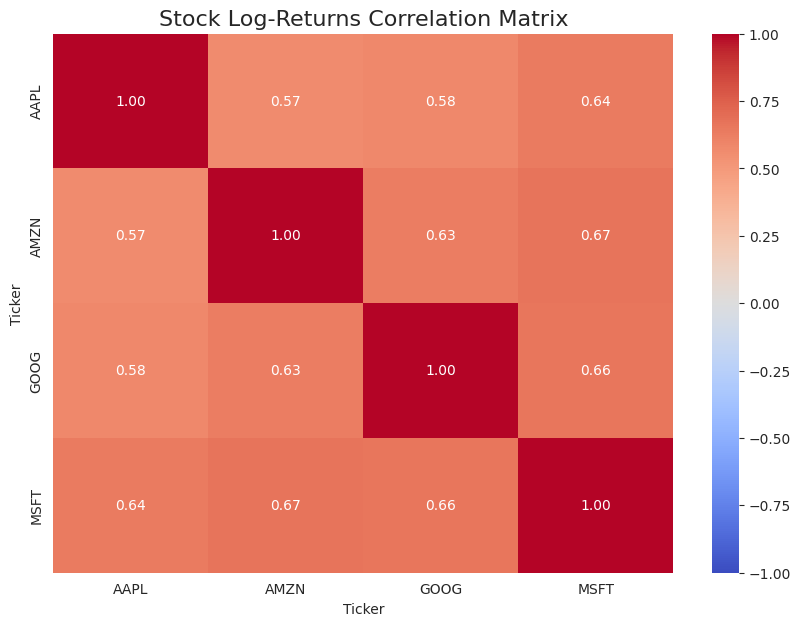

In [17]:
# --- Check if 'log_returns' exists ---
if 'log_returns' in locals() and not log_returns.empty:

    # 1. Calculate the correlation matrix of the log returns
    correlation_matrix = log_returns.corr()

    print("Correlation Matrix:")
    print(correlation_matrix)

    # 2. Visualize the correlation matrix using a heatmap
    plt.figure(figsize=(10, 7))

    # 'annot=True' displays the correlation numbers on the heatmap
    # 'cmap="coolwarm"' uses a blue-to-red color scale
    # 'vmin=-1, vmax=1' sets the color bar range from -1 to 1
    sns.heatmap(correlation_matrix,
                annot=True,
                cmap='coolwarm',
                fmt='.2f',
                vmin=-1,
                vmax=1)

    plt.title('Stock Log-Returns Correlation Matrix', fontsize=16)
    plt.show()

else:
    print("\nCannot calculate correlation because 'log_returns' is not defined.")

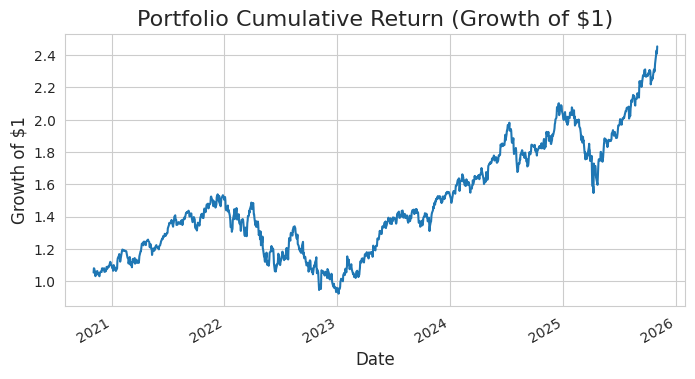

In [18]:
# --- Check if 'portfolio_returns' exists ---
if 'portfolio_returns' in locals() and not portfolio_returns.empty:

    # 1. Convert log returns back to simple returns
    # Formula: simple_return = exp(log_return)
    simple_returns = np.exp(portfolio_returns)

    # 2. Calculate the cumulative return (growth of $1)
    # .cumprod() multiplies each day's return sequentially
    cumulative_return = simple_returns.cumprod()

    # 3. Plot the growth
    plt.figure(figsize=(8, 4))
    cumulative_return.plot()
    plt.title('Portfolio Cumulative Return (Growth of $1)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Growth of $1', fontsize=12)
    plt.show()

else:
    print("\nCannot calculate cumulative return because 'portfolio_returns' is not defined.")


Portfolio Maximum Drawdown: -0.400340
This means the portfolio's worst drop from peak to trough was -40.03%.


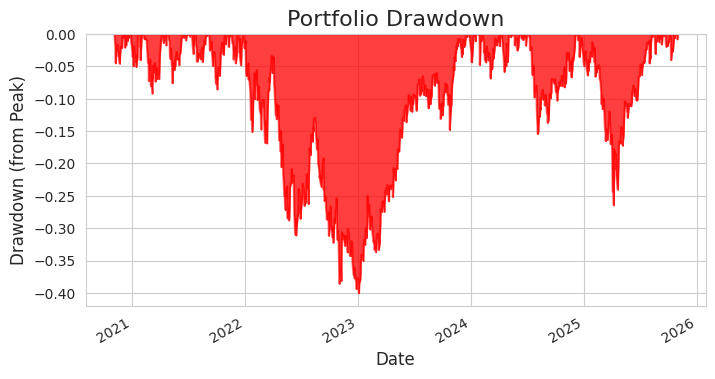

In [19]:
# --- Check if 'cumulative_return' exists ---
if 'cumulative_return' in locals() and not cumulative_return.empty:

    # 1. Calculate the running maximum (the highest peak so far)
    # .cummax() keeps track of the highest value seen up to that point
    running_max = cumulative_return.cummax()

    # 2. Calculate the drawdown (as a percentage from the peak)
    # Formula: (current_value - running_peak) / running_peak
    drawdown = (cumulative_return - running_max) / running_max

    # 3. Find the maximum (worst) drawdown
    max_drawdown = drawdown.min()

    print(f"\nPortfolio Maximum Drawdown: {max_drawdown:.6f}")
    print(f"This means the portfolio's worst drop from peak to trough was {max_drawdown*100:.2f}%.")

    # 4. Plot the drawdown
    plt.figure(figsize=(8, 4))
    drawdown.plot(kind='area', color='red', alpha=0.5)
    plt.title('Portfolio Drawdown', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Drawdown (from Peak)', fontsize=12)
    plt.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.5)
    plt.show()

else:
    print("\nCannot calculate drawdown because 'cumulative_return' is not defined.")

In [20]:
# --- Check if 'portfolio_returns' and 'VaR_historical' exist ---
if 'portfolio_returns' in locals() and 'VaR_historical' in locals():

    # 1. Find all returns that are worse than the historical VaR
    # VaR_historical is already the 5th percentile (a negative number)
    tail_losses = portfolio_returns[portfolio_returns < VaR_historical]

    # 2. Calculate the average of these "tail losses"
    # This is the Historical Expected Shortfall
    ES_historical = tail_losses.mean()

    # 3. Print the result
    print("\n--- Historical Expected Shortfall (ES) ---")
    print(f"Historical VaR (95%): {-VaR_historical:.6f}")
    print(f"Historical ES (95%):  {-ES_historical:.6f}")
    print(f"This means on the worst 5% of days, the average loss was {-ES_historical*100:.2f}%.")

else:
    print("\nCannot calculate Historical ES because 'portfolio_returns' or 'VaR_historical' is not defined.")
    print("Please make sure Code Blocks 12 and 15 have run.")


--- Historical Expected Shortfall (ES) ---
Historical VaR (95%): 0.026443
Historical ES (95%):  0.036411
This means on the worst 5% of days, the average loss was 3.64%.


In [21]:
# --- Check if 'port_mu', 'port_sigma', and 'alpha' exist ---
if 'port_mu' in locals() and 'port_sigma' in locals() and 'alpha' in locals():

    # 1. Get the z-score (e.g., -1.645)
    z_score = norm.ppf(alpha)

    # 2. Calculate the PDF value at the z-score
    phi_z = norm.pdf(z_score)

    # 3. Calculate Parametric ES using the correct formula
    # Formula: ES = mu - sigma * (pdf(z_score) / alpha)
    # This result will be negative (representing a loss)
    ES_calc = port_mu - port_sigma * phi_z / alpha

    # 4. Report the loss as a positive number
    ES_normal = -ES_calc

    # 5. Print the result
    print("\n--- Parametric (Normal) Expected Shortfall (ES) ---")
    print(f"Parametric VaR (95%): {VaR_normal:.6f}")
    print(f"Parametric ES (95%):  {ES_normal:.6f}") # This will now be positive
    print(f"Assuming a normal distribution, on the worst 5% of days, the average loss would be {ES_normal*100:.2f}%.")

else:
    print("\nCannot calculate Parametric ES because portfolio parameters are not defined.")


--- Parametric (Normal) Expected Shortfall (ES) ---
Parametric VaR (95%): 0.025581
Parametric ES (95%):  0.032262
Assuming a normal distribution, on the worst 5% of days, the average loss would be 3.23%.


In [22]:
# --- Check if 'portfolio_returns' and 'VaR_historical' exist ---
if 'portfolio_returns' in locals() and 'VaR_historical' in locals():

    # 1. Find all the days where the actual return was worse than the VaR
    # VaR_historical is a negative number (e.g., -0.02)
    # An exception occurs when the return is even lower than this number
    exceptions = portfolio_returns[portfolio_returns < VaR_historical]

    # 2. Count the number of exceptions
    n_exceptions = len(exceptions)

    # 3. Get the total number of days
    n_total_days = len(portfolio_returns)

    # 4. Calculate the exception rate
    exception_rate = n_exceptions / n_total_days

    # 5. Print the results
    print("\n--- VaR Backtesting Results (Historical VaR) ---")
    print(f"Total trading days:   {n_total_days}")
    print(f"VaR (95%) Threshold:  {VaR_historical:.6f}")
    print(f"Exceptions (Loss > VaR): {n_exceptions}")
    print(f"Expected Exception Rate: {alpha * 100:.2f}%")
    print(f"Actual Exception Rate:   {exception_rate * 100:.2f}%")

    # 6. Interpret the result
    if abs(exception_rate - alpha) < 0.01:  # Check if it's within 1% of expected
        print("\nConclusion: The model is quite accurate. The actual rate is very close to the expected 5%.")
    elif exception_rate < alpha:
        print("\nConclusion: The model is a bit conservative (too safe). It predicted fewer losses than expected.")
    else:
        print("\nConclusion: The model is underestimating risk. Actual losses were more frequent than predicted.")

else:
    print("\nCannot perform Backtest because 'portfolio_returns' or 'VaR_historical' is not defined.")
    print("Please make sure Code Blocks 12 and 15 have run.")


--- VaR Backtesting Results (Historical VaR) ---
Total trading days:   1254
VaR (95%) Threshold:  -0.026443
Exceptions (Loss > VaR): 63
Expected Exception Rate: 5.00%
Actual Exception Rate:   5.02%

Conclusion: The model is quite accurate. The actual rate is very close to the expected 5%.


In [23]:
# --- Check if 'portfolio_returns' and 'alpha' exist ---
if 'portfolio_returns' in locals() and 'alpha' in locals():

    # 1. Define the rolling window size
    window_size = 60  # 60 trading days (approx 3 months)

    # 2. Calculate the rolling 5th percentile (VaR)
    # .rolling(window) creates a 60-day moving window
    # .quantile(alpha) calculates the 5th percentile for each window
    rolling_VaR = portfolio_returns.rolling(window=window_size).quantile(alpha)

    # 3. Drop the initial NaN values (the first 59 days)
    rolling_VaR = rolling_VaR.dropna()

    # Display the last 5 values of the rolling VaR
    print("\n--- Rolling 60-Day Historical VaR (Last 5 Days) ---")
    print(rolling_VaR.tail())

else:
    print("\nCannot calculate Rolling VaR because 'portfolio_returns' or 'alpha' is not defined.")
    print("Please make sure Code Blocks 12 and 13 have run.")


--- Rolling 60-Day Historical VaR (Last 5 Days) ---
Date
2025-10-27   -0.012521
2025-10-28   -0.012521
2025-10-29   -0.012521
2025-10-30   -0.012521
2025-10-31   -0.012521
dtype: float64


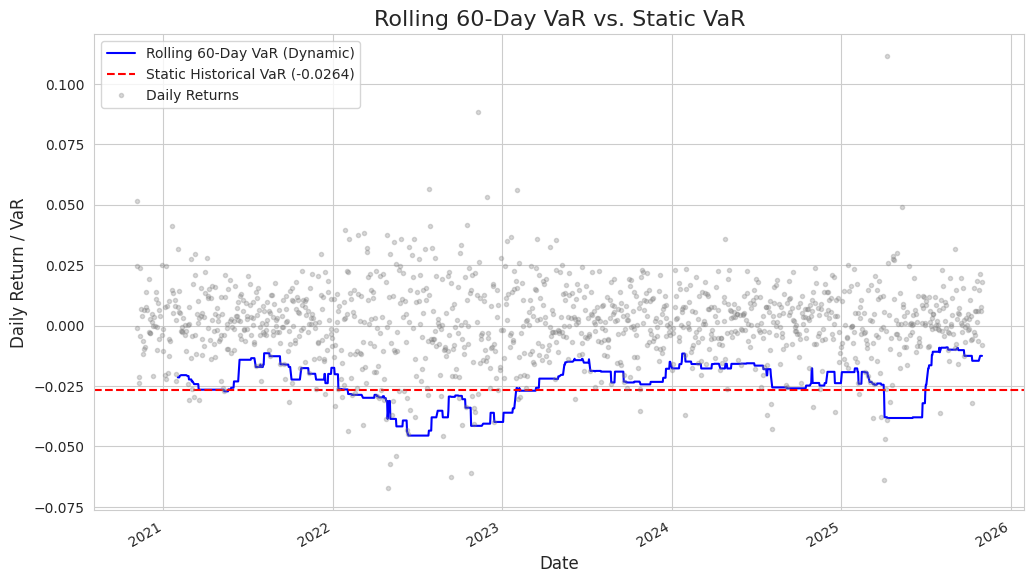

In [24]:
# --- Check if 'rolling_VaR' and 'VaR_historical' exist ---
if 'rolling_VaR' in locals() and 'VaR_historical' in locals():

    # 1. Plot the rolling VaR (as a blue line)
    plt.figure(figsize=(12, 7))
    rolling_VaR.plot(label='Rolling 60-Day VaR (Dynamic)', color='blue')

    # 2. Plot the static (overall) VaR as a straight red line
    # We use VaR_historical, which is a single number
    plt.axhline(y=VaR_historical,
                color='red',
                linestyle='--',
                label=f'Static Historical VaR ({VaR_historical:.4f})')

    # 3. Plot the actual portfolio returns (as light grey dots)
    # This shows where the actual losses occurred
    portfolio_returns.plot(style='.',
                           color='grey',
                           alpha=0.3,
                           label='Daily Returns')

    # 4. Add labels and legend
    plt.title('Rolling 60-Day VaR vs. Static VaR', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Daily Return / VaR', fontsize=12)
    plt.legend()
    plt.show()

else:
    print("\nCannot plot Rolling VaR because 'rolling_VaR' or 'VaR_historical' is not defined.")

In [25]:
from scipy.stats import jarque_bera

# --- Check if 'portfolio_returns' exists ---
if 'portfolio_returns' in locals() and not portfolio_returns.empty:

    # 1. Perform the Jarque-Bera test on the portfolio returns
    jb_statistic, jb_p_value = jarque_bera(portfolio_returns)

    # 2. Print the results
    print("\n--- Normality Test (Jarque-Bera) ---")
    print(f"Jarque-Bera Statistic: {jb_statistic:.6f}")
    print(f"p-value:                 {jb_p_value:.6f}")

    # 3. Interpret the p-value
    alpha = 0.05
    if jb_p_value < alpha:
        print(f"\nConclusion: p-value ({jb_p_value:.6f}) is LESS than {alpha}.")
        print("We REJECT the Null Hypothesis.")
        print("The portfolio's returns are NOT normally distributed.")
        print("This suggests that models assuming normality (like Normal VaR) may be inaccurate.")
    else:
        print(f"\nConclusion: p-value ({jb_p_value:.6f}) is GREATER than {alpha}.")
        print("We FAIL TO REJECT the Null Hypothesis.")
        print("The portfolio's returns are consistent with a normal distribution.")

else:
    print("\nCannot perform Jarque-Bera test because 'portfolio_returns' is not defined.")
    print("Please make sure Code Block 12 has run successfully.")


--- Normality Test (Jarque-Bera) ---
Jarque-Bera Statistic: 642.464478
p-value:                 0.000000

Conclusion: p-value (0.000000) is LESS than 0.05.
We REJECT the Null Hypothesis.
The portfolio's returns are NOT normally distributed.
This suggests that models assuming normality (like Normal VaR) may be inaccurate.
